In [1]:
!pip install evaluate
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [2]:
!pip install opencc
!pip install rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=278638b35c83362023a5f59ad99bddfb76eebbce9b5a29feaa4bbd7c698ecb8b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/766 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/639k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/650k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1088 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/136 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.663 seconds.
DEBUG:jieba:Loading model cost 0.663 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Composite  mean_correct = 0.4241 | mean_incorrect = 0.3750
Paired t-test  t = 39.7737, p = 7.6178e-157
Wilcoxon       W = 120.0000, p = 2.5996e-83


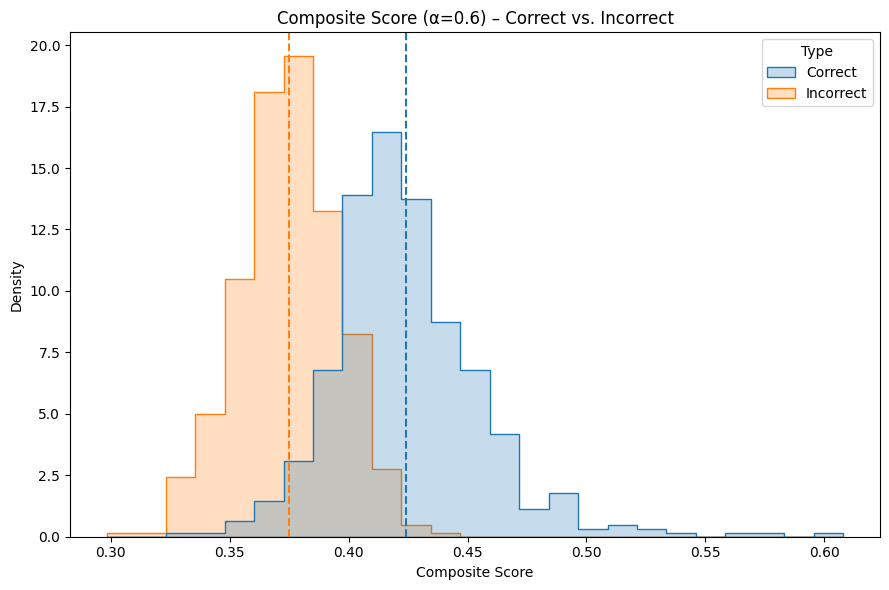

In [3]:
# ============================================================
# 綜合指標：CompositeScore = α * BERT_F1 + (1-α) * ROUGE_F1
# ============================================================

import re, jieba, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats
from typing import List
from datasets import load_dataset

from rouge_score import rouge_scorer, tokenizers
from evaluate import load as load_metric
from transformers import AutoTokenizer

# ---------- 0. 參數 ----------
ALPHA = 0.6          # BERTScore 權重；ROUGE 權重 = 1-ALPHA
TOP_K = 3            # BERTScore 取前 k 高分平均
CHUNK = 512          # BERTScore 每段最長 token
N_SAMPLES = 500      # 評估筆數

# ---------- 1. 資料 ----------
ds = load_dataset("renhehuang/vcsum-meeting-summary")
train_split = ds["train"]
N = min(N_SAMPLES, len(train_split))

# ---------- 2. 前處理工具 ----------
stopwords = {"的", "了", "是", "在", "和", "也", "有", "就", "不", "與"}

def normalize_text(text: str) -> str:
    text = re.sub(r"\s+", "", text)
    text = re.sub(r"[　]", "", text)
    text = re.sub(r"[“”「」『』]", "\"", text)
    text = re.sub(r"[‘’]", "'", text)
    return text.strip()

def remove_stopwords(tokens: List[str]) -> List[str]:
    return [tok for tok in tokens if tok not in stopwords]

class JiebaTokenizer(tokenizers.Tokenizer):
    def tokenize(self, text: str):
        tokens = list(jieba.cut(normalize_text(text)))
        return remove_stopwords(tokens)

# ---------- 3. ROUGE ----------
rouge = rouge_scorer.RougeScorer(
    ["rouge1", "rouge2", "rougeL"],
    use_stemmer=False,
    tokenizer=JiebaTokenizer(),
)

def rouge_f1(text_a: str, text_b: str) -> float:
    parts = ["".join(p) for p in np.array_split(list(normalize_text(text_a)), 2)]
    f1_vals = []
    for seg in parts:
        r = rouge.score(seg, normalize_text(text_b))
        f1_vals.append(
            0.4 * r["rouge1"].fmeasure +
            0.3 * r["rouge2"].fmeasure +
            0.3 * r["rougeL"].fmeasure
        )
    return float(np.mean(f1_vals))

# ---------- 4. BERTScore ----------
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-7B", trust_remote_code=True)
bertscore = load_metric("bertscore")

def bert_f1(text_a: str, text_b: str) -> float:
    # 1) 依 token 切段
    ids = tokenizer.encode(text_a, add_special_tokens=False)
    segments = [
        tokenizer.decode(ids[i : i + CHUNK])
        for i in range(0, len(ids), CHUNK)
    ]

    # 2) 各段 F1
    f1_vals = [
        bertscore.compute(predictions=[seg], references=[text_b], lang="zh")["f1"][0]
        for seg in segments
    ]

    # 3) 取最高 TOP_K 段平均
    top = sorted(f1_vals, reverse=True)[:min(TOP_K, len(f1_vals))]
    return float(np.mean(top))

# ---------- 5. 綜合指標 ----------
def composite_score(text_a: str, text_b: str) -> float:
    r = rouge_f1(text_a, text_b)
    b = bert_f1(text_a, text_b)
    return ALPHA * b + (1 - ALPHA) * r

# ---------- 6. 計算分數 ----------
def to_text(x):
    return " ".join(x) if isinstance(x, list) else str(x)

correct, incorrect = [], []

for i in range(N):
    ctx   = to_text(train_split[i]["context"])
    summ  = to_text(train_split[i]["discussion"])
    wrong = to_text(train_split[(i + 1) % len(train_split)]["discussion"])

    correct.append(composite_score(ctx, summ))
    incorrect.append(composite_score(ctx, wrong))

# ---------- 7. 統計檢定 ----------
t_stat, t_p  = stats.ttest_rel(correct, incorrect)
w_stat, w_p  = stats.wilcoxon(correct, incorrect)
print(f"Composite  mean_correct = {np.mean(correct):.4f} | mean_incorrect = {np.mean(incorrect):.4f}")
print(f"Paired t-test  t = {t_stat:.4f}, p = {t_p:.4e}")
print(f"Wilcoxon       W = {w_stat:.4f}, p = {w_p:.4e}")

# ---------- 8. 可視化 ----------
df = pd.DataFrame({"Score": correct + incorrect,
                   "Type": ["Correct"]*N + ["Incorrect"]*N})

plt.figure(figsize=(9,6))
sns.histplot(data=df, x="Score", hue="Type", stat="density",
             common_norm=False, element="step", bins=25)
plt.axvline(np.mean(correct), color="tab:blue", linestyle="--")
plt.axvline(np.mean(incorrect), color="tab:orange", linestyle="--")
plt.xlabel("Composite Score")
plt.ylabel("Density")
plt.title(f"Composite Score (α={ALPHA}) – Correct vs. Incorrect")
plt.tight_layout()
plt.show()


❶ 錯判筆數: 4/500  (0.80 %)
❷ Cohen's d = 1.779  (95 % CI [1.567, 1.944])
❸ ROC AUC = 0.925


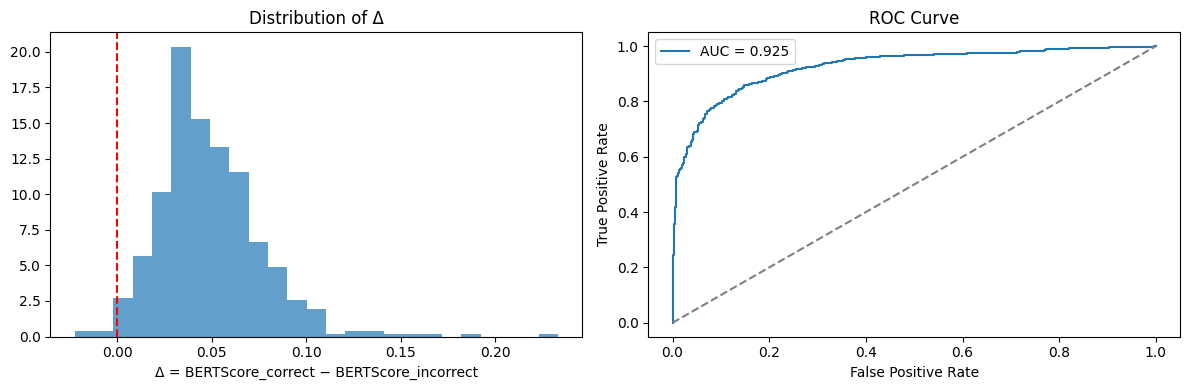


❹ Top 10 錯判樣本（Δ 最小）索引與差值
  idx  116 | Δ = -0.0224
  idx   29 | Δ = -0.0173
  idx   77 | Δ = -0.0065
  idx   16 | Δ = -0.0040
  idx  209 | Δ = +0.0006
  idx  330 | Δ = +0.0017
  idx   46 | Δ = +0.0018
  idx   14 | Δ = +0.0035
  idx   99 | Δ = +0.0039
  idx  189 | Δ = +0.0053
=== Correct ===
mean: 0.42413860665268055 std: 0.03172171993770833
=== Incorrect ===
mean: 0.3750069420705371 std: 0.020541246294740866

=== Paired t-test (Correct − Incorrect) ===
t-statistic : 39.7737
p-value     : 7.6178e-157

=== Wilcoxon signed-rank ===
W statistic : 120.0000
p-value     : 2.5996e-83

結論：t-test 為 顯著；Wilcoxon 為 顯著 (α = 0.01)


In [5]:
# ------------------------------------------------------------------
# 既有變數：
#   correct_scores     (list[float])
#   incorrect_scores   (list[float])
#   N                  (樣本筆數)
# ------------------------------------------------------------------

import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from scipy.stats import ttest_rel
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
correct_scores = correct
incorrect_scores = incorrect
# ---------- 2.1 量化錯判比例 ----------
delta = np.array(correct_scores) - np.array(incorrect_scores)
misrank_count = np.sum(delta <= 0)
misrank_pct   = misrank_count / len(delta) * 100
print(f"❶ 錯判筆數: {misrank_count}/{len(delta)}  ({misrank_pct:.2f} %)")

# ---------- 2.2 效應量 (Cohen’s d) + 95 % Bootstrap CI ----------
def cohens_d(x, y):
    diff = np.array(x) - np.array(y)
    return diff.mean() / diff.std(ddof=1)

d_obs = cohens_d(correct_scores, incorrect_scores)

# bootstrap CI
rng = np.random.default_rng(seed=42)
boot_res = bootstrap(
    data=(np.array(correct_scores), np.array(incorrect_scores)),
    statistic=lambda a, b: cohens_d(a, b),
    vectorized=False,
    paired=True,
    confidence_level=0.95,
    n_resamples=10_000,
    random_state=rng
)
ci_low, ci_high = boot_res.confidence_interval
print(f"❷ Cohen's d = {d_obs:.3f}  (95 % CI [{ci_low:.3f}, {ci_high:.3f}])")

# ---------- 2.3 ROC / AUC ----------
y_true   = np.r_[np.ones_like(correct_scores), np.zeros_like(incorrect_scores)]
y_score  = np.r_[correct_scores, incorrect_scores]

fpr, tpr, thr = roc_curve(y_true, y_score)
auc_val = auc(fpr, tpr)
print(f"❸ ROC AUC = {auc_val:.3f}")

# ---------- 2.4 視覺化 ----------
plt.figure(figsize=(12, 4))

# Δ 分佈
plt.subplot(1, 2, 1)
plt.hist(delta, bins=25, density=True, alpha=0.7)
plt.axvline(0, color="r", linestyle="--")
plt.xlabel("Δ = BERTScore_correct − BERTScore_incorrect")
plt.title("Distribution of Δ")

# ROC 曲線
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()

# ---------- 2.5 列出錯判 Top-k ----------
k = 10
worst_idx = np.argsort(delta)[:k]  # 最負的差值
print(f"\n❹ Top {k} 錯判樣本（Δ 最小）索引與差值")
for idx in worst_idx:
    print(f"  idx {idx:4d} | Δ = {delta[idx]:+.4f}")
# 之後可用 filt_train[idx]["context"] 取回原文做人工分析

# ------------------------- 5. 基本統計 --------------------------
print("=== Correct ===")
print("mean:", np.mean(correct_scores), "std:", np.std(correct_scores))
print("=== Incorrect ===")
print("mean:", np.mean(incorrect_scores), "std:", np.std(incorrect_scores))

# ------------------------- 6. 統計檢定 ---------------------------
from scipy.stats import ttest_rel, wilcoxon

# 6-1  配對 t-test
t_stat, p_val = ttest_rel(correct_scores, incorrect_scores)

print("\n=== Paired t-test (Correct − Incorrect) ===")
print(f"t-statistic : {t_stat:.4f}")
print(f"p-value     : {p_val:.4e}")

# 6-2  非參數備案：Wilcoxon signed-rank
w_stat, w_p = wilcoxon(correct_scores, incorrect_scores, zero_method="zsplit")

print("\n=== Wilcoxon signed-rank ===")
print(f"W statistic : {w_stat:.4f}")
print(f"p-value     : {w_p:.4e}")

# 可自行設定顯著水準做判斷
alpha = 0.01
sig_t  = "顯著" if p_val < alpha else "不顯著"
sig_w  = "顯著" if w_p   < alpha else "不顯著"
print(f"\n結論：t-test 為 {sig_t}；Wilcoxon 為 {sig_w} (α = {alpha})")